# Outils de calcul du gradient et construction d'un réseau de neurones en Python

Ce notebook est dérivé du travail d'[Andrej Karpathy](https://karpathy.ai/) et reprend pas à pas les étapes exposées dans sa première séance de cours sur la construction d'un outil en Python pour le calcul du gradient et sa propagation arrière:

[The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

Cette séance fait partie [d'un cours très complet](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) allant jusqu'à la construction d'un réseau de neurones génératif avec une architecture Transformer de type GPT.

Voici les ressources originales associées à la vidéo youtube d'Andrej:

- micrograd on github: https://github.com/karpathy/micrograd
- notebook original: https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd
- exercices: https://colab.research.google.com/drive/1FPTx1RXtBfc4MaTkf7viZZD4U2F9gtKN?usp=sharing


## Importation des paquetages python nécessaires

Le paquetage `graphviz` utilisé ici nécessite la commande `graphviz` sur la machine faisant fonctionner ce notebook. Sur un système Linux de type Debian/Ubuntu, cette commande s'installe avec `apt install graphviz`.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

## Représentation d'une fonction mathématique avec sa dérivée

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

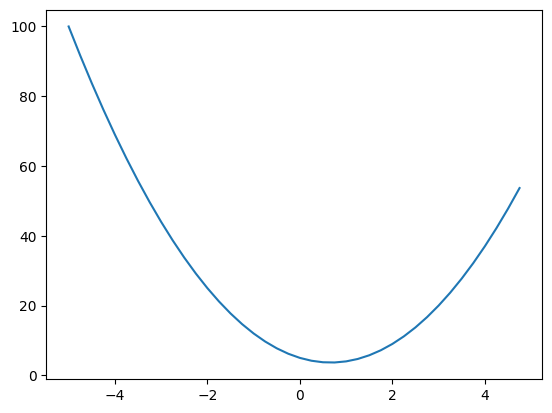

In [4]:
xs = np.arange(-5, 5, 0.25)
#print(xs)
ys = f(xs)
#print(ys)
plt.plot(xs,ys)

$$f'(x_0) = \lim_{h \to 0\atop h\ne0} t_{x_0}(h) = \lim_{h \to 0\atop h\ne0}{f(x_0+h)-f(x_0) \over h}$$

Pour une fonction $f : U \subset \mathbb{R} \to \mathbb{R}$, le gradient de $f$ se confond avec la dérivée de $f$.

In [5]:
h = 0.000001
x = 3.0
f(x)

20.0

In [6]:
f(x+h)

20.000014000003002

In [7]:
(f(x+h)-f(x))/h

14.000003002223593

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [9]:
d1 = a*b + c
h = 0.0001
b += h
d2 = a*b + c
tx = (d2-d1)/h
tx

2.0000000000042206

In [89]:
class Value:

    def __init__(self, data, children=(), operation=''):
        self.data = data
        self.previous = set(children)
        self.operation = operation

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c;
d


Value(data=-6.0)

In [11]:
d.previous

{Value(data=-6.0), Value(data=10.0)}

In [12]:
d.operation

'+'

In [91]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.previous:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ data %.4f }" % n.data, shape='record')
    if n.operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

  return dot

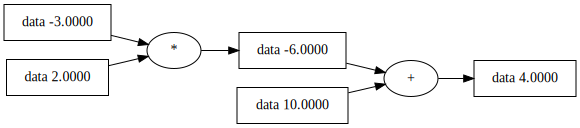

In [92]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c;
draw_dot(d)

## Label et nouvelle fonction exemple avec une ébauche de fonction objectif

In [93]:
# Nouvelle version, ajout d'un label

class Value:

    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.previous = set(children)
        self.operation = operation
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, op={self.operation})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [94]:
# Utilisation du label dans l'affichage

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n.operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

  return dot

In [95]:
# Expression avec une fonction L qui préfigure la fonction de perte
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b
d.label = 'd'
e = d + c
e.label = 'e'
f = Value(-2.0, label='f')
L = e * f
L.label = 'L'

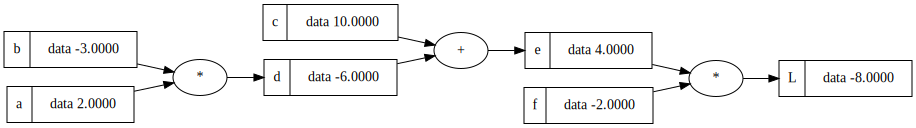

In [96]:
draw_dot(L)

In [97]:
# Nouvelle version, ajout du gradient

class Value:

    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.gradient = 0
        self.previous = set(children)
        self.operation = operation
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, op={self.operation})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b
d.label = 'd'
e = d + c
e.label = 'e'
f = Value(-2.0, label='f')
L = e * f
L.label = 'L'

In [98]:
# Ajout du gradient dans l'affichage

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.previous:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | gradient %.4f }" % (n.label, n.data, n.gradient), shape='record')
    if n.operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

  return dot

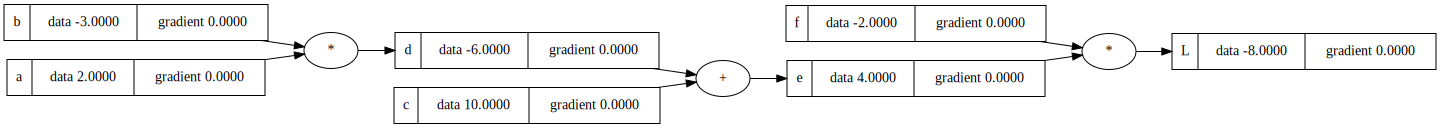

In [99]:
draw_dot(L)

Forward pass of the computation of the expression with input values $a$, $b$, $c$, and $f$. Output of the forward pass if $-8$. Now we'd like to run back propagation, calculating the gradients along all the expression going backward. We'll compute the derivative of each value with respect to $L$. In neural network settings, we'll be interesting by the derivative of the loss function $L$ with respect to the weights of the neural network. "poids des noeuds qui impactent la fonction de perte" Leaf nodes.

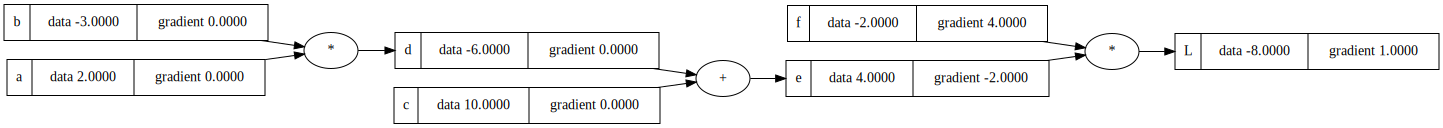

In [101]:
# Calcul des gradients "à la main" pour f et e
L.gradient = 1.0
e.gradient = -2.0  # dL/de = d(f*e)/de = f
f.gradient = 4.0  # dL/df = d(f*e)/de = e
draw_dot(L)

In [23]:
# Fonction de démonstration pour le calcul de tous les gradients

def compute_gradient():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    d = a*b
    d.label = 'd'
    e = d + c
    e.label = 'e'
    f = Value(-2.0, label='f')
    L = e * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    # a.data += h  # a.gradient
    b = Value(-3.0, label='b')
    # b.data += h  # b.gradient
    c = Value(10.0, label='c')
    #c.data += h  # c.gradient
    d = a*b
    d.label = 'd'
    #d.data += h  # d.gradient
    e = d + c
    e.label = 'e'
    #e.data += h  # e.gradient
    f = Value(-2.0, label='f')
    #f.data += h  # f.gradient
    L = e * f
    L.label = 'L'
    L2 = L.data
    # L2 += h  # L.gradient
    
    print((L2-L1)/h)

compute_gradient()


0.0


## Propagation arrière des gradients à la main


In [24]:
# dL/dc ? Impact on L of a slight change of c trough e ?
# Let's compute de/dc
# e = c + d  so d(c+d)/dc = 1.0 and d(c+d)/dd = 1.0  Local derivatives
# How it is impacting L ?
# Chain rule: https://en.wikipedia.org/wiki/Chain_rule

$$\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}$$

Intuitively, the chain rule states that knowing the instantaneous rate of change of $z$ relative to $y$ and that of $y$ relative to $x$ allows one to calculate the instantaneous rate of change of $z$ relative to $x$ as the product of the two rates of change. 

As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

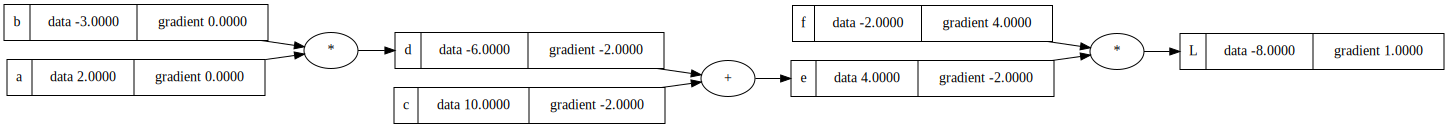

In [102]:
d.gradient = e.gradient
c.gradient = e.gradient
draw_dot(L)

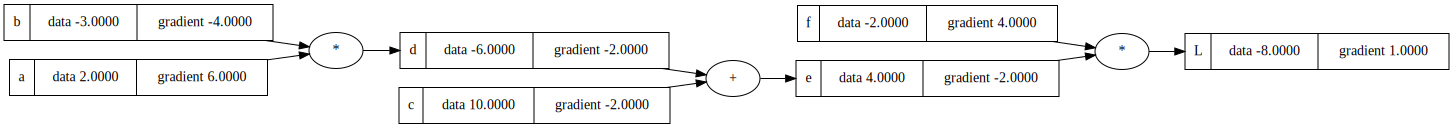

In [103]:
# a.gradient = dL/da = dL/dd * dd/da = d.gradient * d(a*b)/da = d.gradient * b.data
# b.gradient = dL/db = dL/dd * dd/db = d.gradient * d(a*b)/db = d.gradient * a.data
a.gradient = d.gradient * b.data
b.gradient = d.gradient * a.data
draw_dot(L)

Back propagation du gradient done manually. Recursively propagating the gradient with the chain rule.

Now we are going to nudge the ouput and trying to make $L$ go up.

In [27]:
a.data += 0.01 * a.gradient
b.data += 0.01 * b.gradient
c.data += 0.01 * c.gradient
f.data += 0.01 * f.gradient
d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
L = e * f; L.label = 'L'
print(L)
# Learning pass...

Value(data=-7.286496, label=L, op=*)


In [28]:
# Google: cs231n neuron 

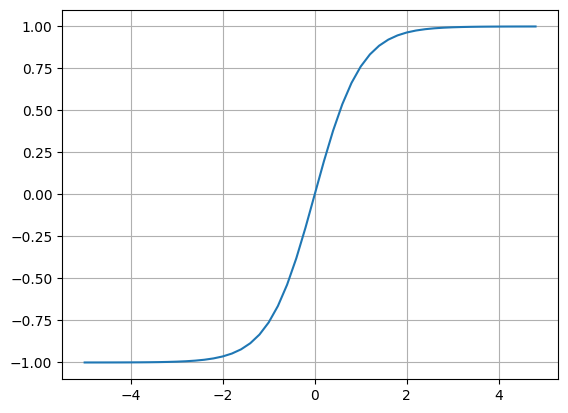

In [29]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()  # Activation function (tanh or sigmoid)

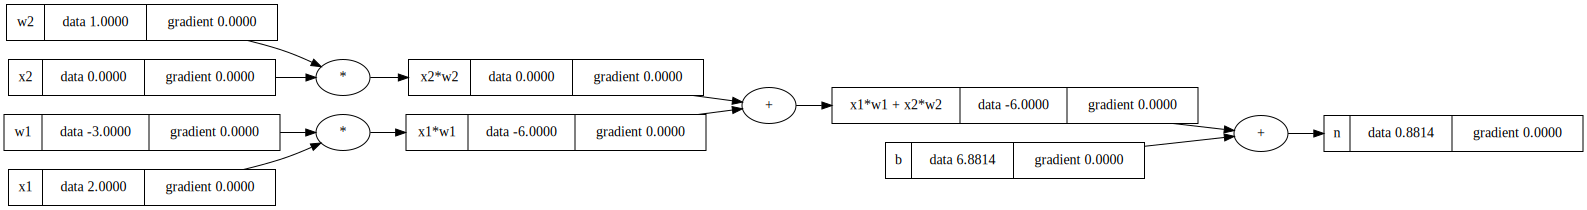

In [30]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
draw_dot(n)

In [105]:
# Let's add tanh to our Value's methods
# tanh is an hyperbolic function: https://en.wikipedia.org/wiki/Hyperbolic_functions

class Value:

    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.gradient = 0
        self.previous = set(children)
        self.operation = operation
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, op={self.operation})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out


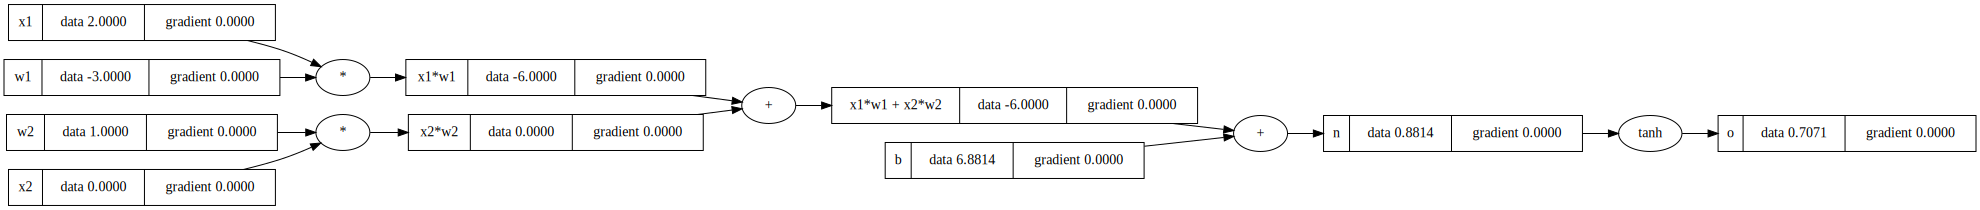

In [106]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')  # Magic value for nice back prop
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [33]:
o.gradient = 1.0
n.gradient = 1 - o.data**2  # o = tanh(n) ; do/dn = 1 - tanh(n)**2 = 1 - o.data**2 

In [34]:
print(n.gradient)

0.4999999999999999


In [35]:
n.gradient = 0.5

In [36]:
x1w1x2w2.gradient = n.gradient
x1w1.gradient = x1w1x2w2.gradient
x2w2.gradient = x1w1x2w2.gradient
x2.gradient = w2.data * x2w2.gradient
w2.gradient = x2.data * x2w2.gradient
x1.gradient = w1.data * x1w1.gradient
w1.gradient = x1.data * x1w1.gradient

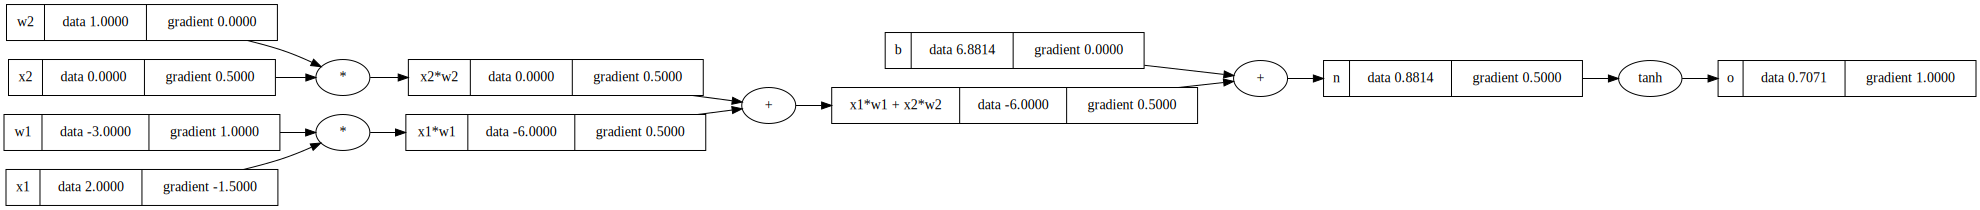

In [37]:
draw_dot(o)

1h08 dans la vidéo.

"*Doing that by hand is ridiculous. Let's code it in Value class.*"

## Méthodes pour la propagation arrière du gradient

In [112]:
class Value:

    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.gradient = 0
        self.previous = set(children)
        self.operation = operation
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, op={self.operation})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():  # Cloture fonctionnant par effet de bord
            self.gradient = 1.0 * out.gradient  # gradient local (1.0) fois gradient back
            other.gradient = 1.0 * out.gradient  # gradient local (1.0) fois gradient back
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():  # Cloture fonctionnant par effet de bord
            self.gradient = other.data * out.gradient  # gradient local (other.data) fois gradient back
            other.gradient = self.data * out.gradient  # gradient local (self.data) fois gradient back
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():  # Cloture fonctionnant par effet de bord
            self.gradient = (1 - t**2) * out.gradient  # gradient local ($1-t^2$) fois gradient back
        out._backward = _backward
        return out

In [113]:
# Définition des expressions
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')  # Magic value for nice back prop
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

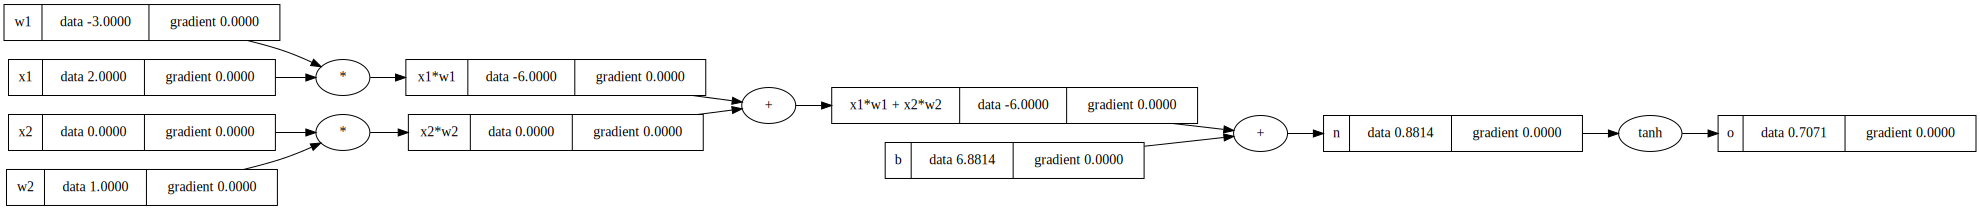

In [114]:
draw_dot(o)

In [115]:
o.gradient = 1.0
o._backward()  # Back propagation du gradient "à travers" tanh()

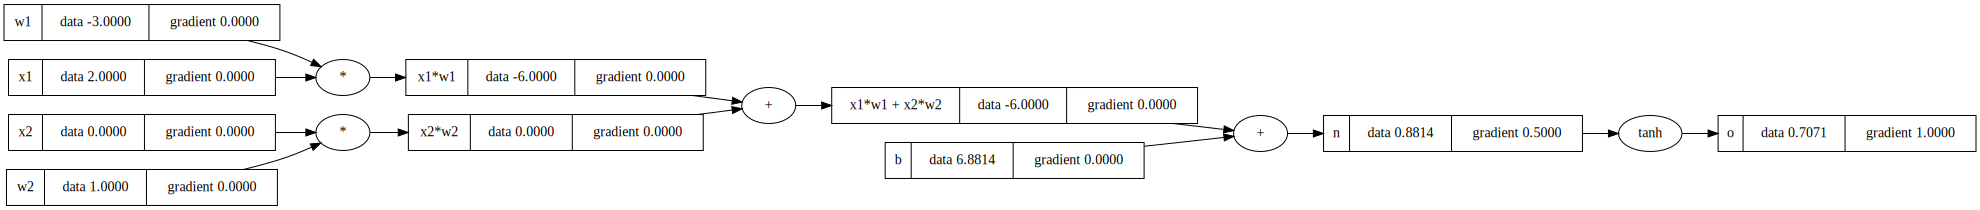

In [116]:
draw_dot(o)

In [119]:
n._backward()

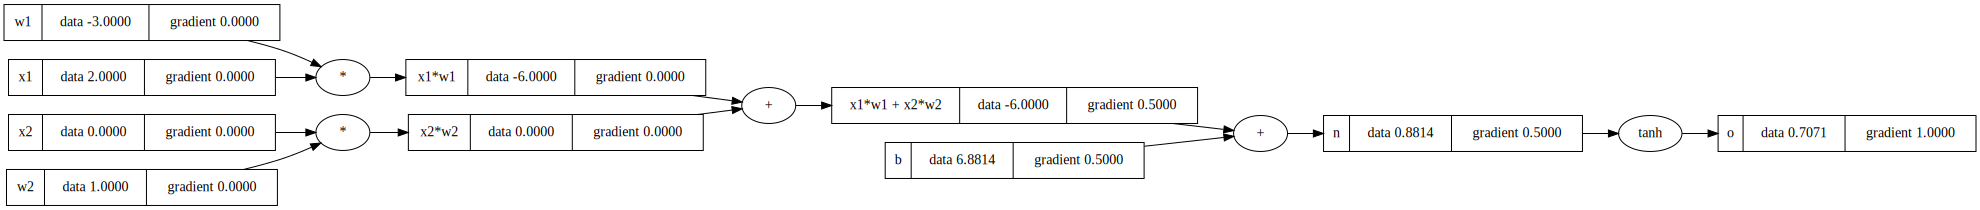

In [120]:
draw_dot(o)

In [121]:
b._backward()
x1w1x2w2._backward()

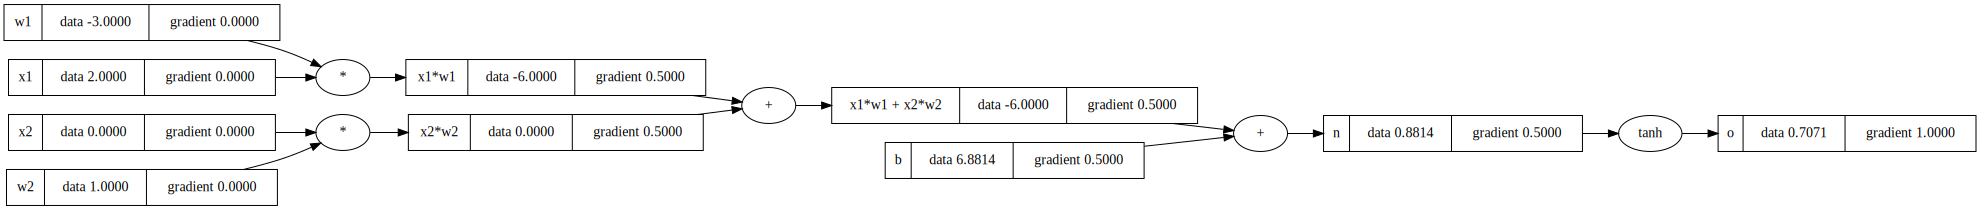

In [122]:
draw_dot(o)

In [123]:
x1w1._backward()
x2w2._backward()

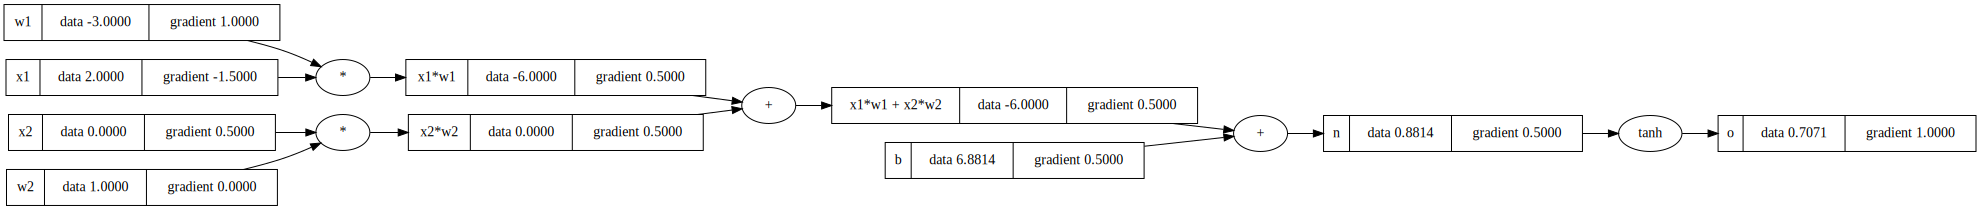

In [124]:
draw_dot(o)


In [126]:
# Passer d'un mode manuel à une automatisation de la back propagation
# Tri topologique du DAG de l'expression
def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.previous:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.gradient = 1.0
    for node in reversed(topo):
      node._backward()
Value.backward = backward

In [127]:
# Définition des expressions
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')  # Magic value for nice back prop
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [128]:
o.backward()

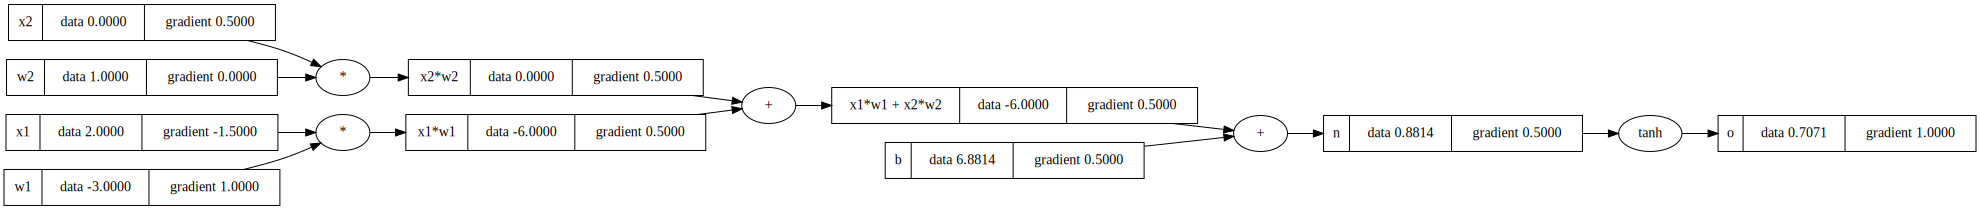

In [129]:
draw_dot(o)

In [53]:
# MAIS Il y a toujours un soucis

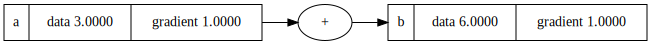

In [54]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

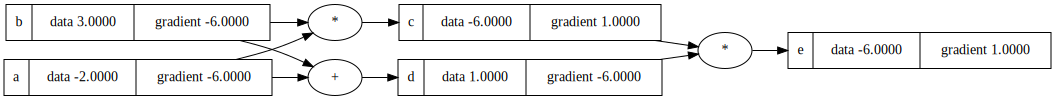

In [55]:
# a vers b est une double flêche, la propagation "avant" fonctionne, mais l'arrière non
# db/da devrait être 2
# C'est également un problème ici:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a * b; c.label = 'c'
d = a + b; d.label = 'd'
e = c * d; e.label = 'e'
e.backward()
draw_dot(e)

In [130]:
import math

# Il faut accumuler les gradients
class Value:

    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.gradient = 0
        self.previous = set(children)
        self.operation = operation
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, op={self.operation})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():  # Cloture fonctionnant par effet de bord
            self.gradient += 1.0 * out.gradient  # gradient local (1.0) fois gradient back
            other.gradient += 1.0 * out.gradient  # gradient local (1.0) fois gradient back
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():  # Cloture fonctionnant par effet de bord
            self.gradient += other.data * out.gradient  # gradient local (other.data) fois gradient back
            other.gradient += self.data * out.gradient  # gradient local (self.data) fois gradient back
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():  # Cloture fonctionnant par effet de bord
            self.gradient += (1 - t**2) * out.gradient  # gradient local ($1-t^2$) fois gradient back
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v.previous:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.gradient = 1.0
        for node in reversed(topo):
          node._backward()

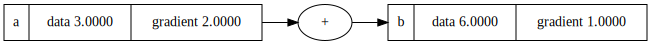

In [131]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

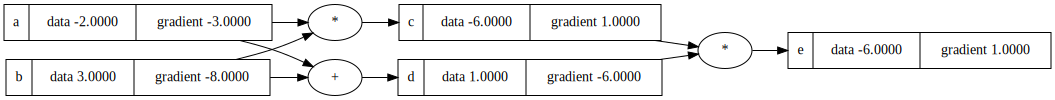

In [132]:
# a vers b est une double flêche, la propagation "avant" fonctionne, mais l'arrière non
# db/da devrait être 2
# C'est également un problème ici:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a * b; c.label = 'c'
d = a + b; d.label = 'd'
e = c * d; e.label = 'e'
e.backward()
draw_dot(e)

On pourrait détailler tanh en atomes explicites.

$$\operatorname{tanh}(x) = \frac{\operatorname{sinh}(x)}{\operatorname{cosh}(x)} = \frac{{\rm e}^x-{\rm e}^{-x}}{{\rm e}^x+{\rm e}^{-x}}=\frac{{\rm e}^{2x}-1}{{\rm e}^{2x}+1}=1-\frac 2{{\rm e}^{2x}+1}$$


## Nouvelles méthodes pour avoir d'autres expressions 

In [133]:
import math

# Il faut accumuler les gradients
class Value:

    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.gradient = 0
        self.previous = set(children)
        self.operation = operation
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, op={self.operation})"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():  # Cloture fonctionnant par effet de bord
            self.gradient += 1.0 * out.gradient  # gradient local (1.0) fois gradient back
            other.gradient += 1.0 * out.gradient  # gradient local (1.0) fois gradient back
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():  # Cloture fonctionnant par effet de bord
            self.gradient += other.data * out.gradient  # gradient local (other.data) fois gradient back
            other.gradient += self.data * out.gradient  # gradient local (self.data) fois gradient back
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.gradient += other * (self.data ** (other - 1)) * out.gradient
        out._backward = _backward
        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():  # Cloture fonctionnant par effet de bord
            self.gradient += (1 - t**2) * out.gradient  # gradient local ($1-t^2$) fois gradient back
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
          self.gradient += out.data * out.gradient
        out._backward = _backward
        return out
      
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v.previous:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.gradient = 1.0
        for node in reversed(topo):
          node._backward()

In [134]:
a = Value(3.0, label='a')
a + 1

Value(data=4.0, label=, op=+)

In [135]:
a = Value(3.0, label='a')
1 + a

Value(data=4.0, label=, op=+)

In [136]:
a = Value(3.0, label='a')
a * 2

Value(data=6.0, label=, op=*)

In [63]:
a = Value(3.0, label='a')
2 * a

Value(data=6.0, label=, op=*)

In [64]:
a = Value(3.0, label='a')
a**2

Value(data=9.0, label=, op=**2)

In [65]:
a = Value(3.0, label='a')
b = Value(2.0, label='a')
a / b

Value(data=1.5, label=, op=*)

In [66]:
a = Value(3.0, label='a')
b = Value(2.0, label='a')
a - b

Value(data=1.0, label=, op=+)

In [67]:
a = Value(3.0, label='a')
-a

Value(data=-3.0, label=, op=*)

In [68]:
a = Value(3.0, label='a')
a.exp()

Value(data=20.085536923187668, label=, op=exp)

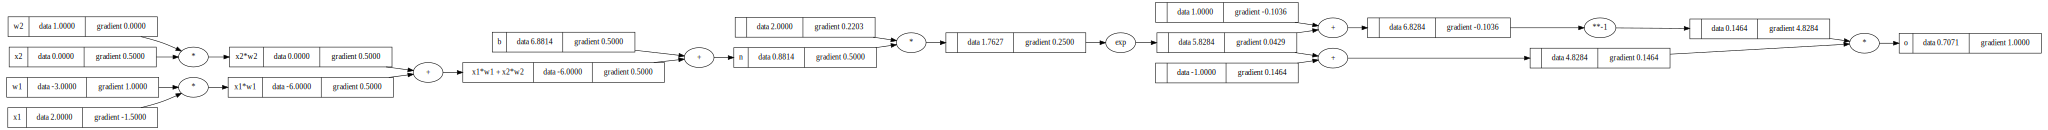

In [137]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

## Parenthèse: même graphe en PyTorch

Pour que cette section fonctionne, il est nécessaire que PyTorch soit installé sur la machine faisant tourner Jupyter (`pip install torch`). Ne pas exécuter cette fonction si ce n'est pas le cas. Cette section est illustrative et n'est pas nécessaire pour la suite du notebook.

In [138]:
import torch

In [139]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [140]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA RTX A2000 Laptop GPU


## Construction d'un Perceptron Multi Couches (MLP)

https://www.jeremyjordan.me/intro-to-neural-networks/

![Simple neuron](https://www.jeremyjordan.me/content/images/2018/01/single_neuron.jpg)

In [151]:
import random

class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]


In [74]:
n = Neuron(5)
n((4, 3, 4, 6, 5))

Value(data=-0.9999515884894994, label=, op=tanh)

https://cs231n.github.io/neural-networks-1/

![MLP](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [150]:
class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [152]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.3746439590984476, label=, op=tanh)

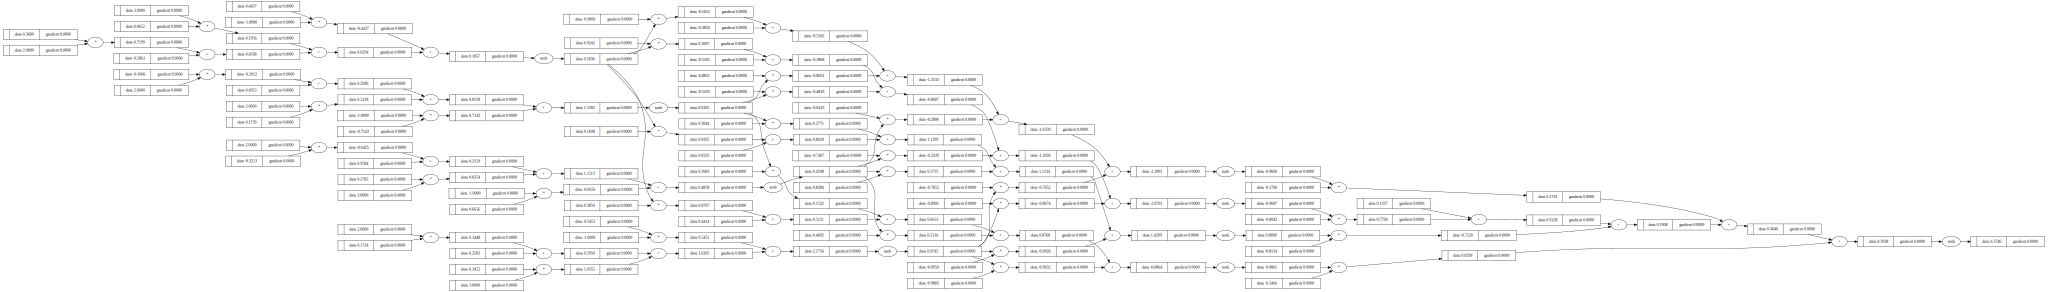

In [153]:
draw_dot(n(x))

In [154]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [155]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.3746439590984476, label=, op=tanh),
 Value(data=-0.5298853806693812, label=, op=tanh),
 Value(data=-0.10679681413216288, label=, op=tanh),
 Value(data=0.4677361651047318, label=, op=tanh)]

In [156]:
# How to tune the weights?

In [157]:
# Calculer la perte permettant de mesurer la performance de notre réseau
# On va vouloir minimiser le loss
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.39107017789206405, label=, op=**2),
 Value(data=0.22100775530837263, label=, op=**2),
 Value(data=0.7978119312444539, label=, op=**2),
 Value(data=0.2833047899374173, label=, op=**2)]

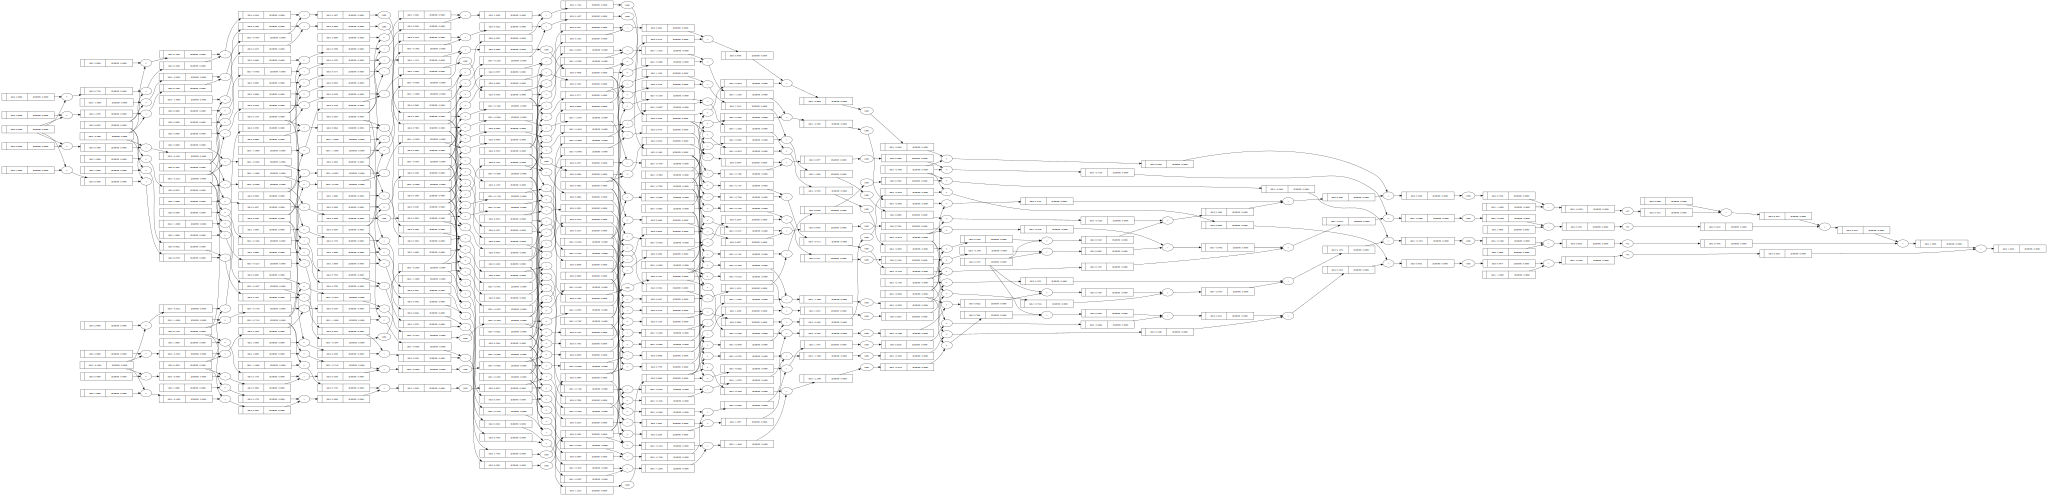

In [158]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss
draw_dot(loss)

In [159]:
# le loss doit être le plus petit possible
loss.backward()

In [160]:
n.layers[0].neurons[0].w[0].gradient

-0.48175685903456256

In [161]:
n.layers[0].neurons[0].w[1].gradient

0.44854343749549863

In [86]:
#draw_dot(loss)

In [162]:
n.parameters()

[Value(data=0.35996431429736186, label=, op=),
 Value(data=0.06519365669100519, label=, op=),
 Value(data=0.4437228016842345, label=, op=),
 Value(data=-0.2860967314859484, label=, op=),
 Value(data=-0.10062422223592637, label=, op=),
 Value(data=0.17393253140121567, label=, op=),
 Value(data=-0.7143496460415957, label=, op=),
 Value(data=0.4952865394020931, label=, op=),
 Value(data=-0.32125385658024697, label=, op=),
 Value(data=0.27846025822109044, label=, op=),
 Value(data=0.6655559457996088, label=, op=),
 Value(data=0.9584404650224023, label=, op=),
 Value(data=0.1723805062863708, label=, op=),
 Value(data=0.3451615397509653, label=, op=),
 Value(data=-0.5450959532336623, label=, op=),
 Value(data=0.25026952088998144, label=, op=),
 Value(data=0.9242277804887511, label=, op=),
 Value(data=-0.5292571132429242, label=, op=),
 Value(data=-0.7406956268974245, label=, op=),
 Value(data=-0.8900917065114078, label=, op=),
 Value(data=-0.5565024588142136, label=, op=),
 Value(data=0.1607

In [163]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.gradient = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.gradient  # Descente
    # Voir le gradient comme un vecteur pointant vers un loss qui augmente
  
  print(k, loss.data)

0 1.6931946543823078
1 0.44329318775163273
2 0.13151054238725127
3 0.05613502126493772
4 0.04277101749952209
5 0.03470731150955811
6 0.029235013502704014
7 0.025263124950650778
8 0.022244972356413654
9 0.01987253773122642
10 0.017958127156923666
11 0.016380574209207962
12 0.015058070703924394
13 0.013933350396291354
14 0.012965113086739227
15 0.012122816332032204
16 0.011383383848721885
17 0.010729054053215649
18 0.010145932620598822
19 0.00962299394763327


In [164]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9631443241040689, label=, op=tanh),
 Value(data=-0.9705739759243885, label=, op=tanh),
 Value(data=-0.9394733941032682, label=, op=tanh),
 Value(data=0.9428714152104302, label=, op=tanh)]